### IMPORTS

In [1]:
# load, preprocess, scale, baseline
from wrangle import final_dataset

# manipulate data
import numpy as np

# visualize data
import matplotlib.pyplot as plt
import seaborn as sn

# neural network weights
from modelsNN import good_weights

# optmization problem
from modelsRO import good_problem

np.random.seed(123)

### Load, Clean, Preprocess, Scale, Baseline: Cardiovascular Disease

In [2]:
X_train_scaled_cd, X_test_scaled_cd, y_train_cd, y_test_cd = final_dataset(dataset='cvd')

CVD Loading and Cleaning...
CVD Loaded and Cleaned...

CVD Splitting...
CVD Split...

CVD Scaling...
CVD Scaled...



### Modeling: Cardiovascular Disease

In [3]:
%%time
nn = good_weights(X_train_scaled_cd, y_train_cd,
                  X_test_scaled_cd, y_test_cd)

Running All Algorithms
Running Random Hill Climbing
Running Simulated Annealing
Running Genetic Algorithm
Running Gradient Descent
Compmleted All Algorithms
Time (Seconds): 6.318092346191406e-05
Time (Minutes): 1.0530153910319011e-06 

Working on: Random Hill Climbing
Fitting: Random Hill Climbing
Model Fitting Complete. Time: 320.80911207199097 seconds

Predicting (TRAINING): Random Hill Climbing

Calculating Recall (TRAINING): Random Hill Climbing

Appending Results (TRAINING): Random Hill Climbing

Recall Score (TRAINING): 0.692687514695509%

Predicting (TESTING): Random Hill Climbing

Calculting Recall (TESTING): Random Hill Climbing

Appending Results (TESTING): Random Hill Climbing

Recall Score (TESTING): 0.6897470039946738%


Working on: Simulated Annealing
Fitting: Simulated Annealing
Model Fitting Complete. Time: 2.0648722648620605 seconds

Predicting (TRAINING): Simulated Annealing

Calculating Recall (TRAINING): Simulated Annealing

Appending Results (TRAINING): Simulated A

In [4]:
nn['Random Hill Climbing']

{'nn': NeuralNetwork(clip_max=1, curve=True, hidden_nodes=[4], max_iters=300,
               random_state=123, restarts=200),
 'y_train_pred': array([[1],
        [1],
        [1],
        ...,
        [0],
        [1],
        [1]]),
 'recall_train': 0.692687514695509,
 'y_test_pred': array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [1]]),
 'recall_test': 0.6897470039946738}

### Optimization Problem: Cardiovascular Disease

In [5]:
%%time
opt_prob = good_problem()

Running All Algorithms

Running Random Hill Climbing
Running Random Hill Climbing FourPeaks
Completed Random Hill Climbing FourPeaks. Time: 1.1574408849080404 minutes.
Running Random Hill Climbing FlipFlop
Completed Random Hill Climbing FlipFlop. Time: 1.1820507367451987 minutes.
Running Random Hill Climbing Knapsack
Completed Random Hill Climbing Knapsack. Time: 1.212269171079 minutes.
Completed Random Hill Climbing. Time: 3.5517607927322388 minutes

Running Random Hill Climbing
Running Random Hill Climbing FourPeaks
Completed Random Hill Climbing FourPeaks. Time: 1.2134822289148965 minutes.
Running Random Hill Climbing FlipFlop
Completed Random Hill Climbing FlipFlop. Time: 1.2148308316866556 minutes.
Running Random Hill Climbing Knapsack
Completed Random Hill Climbing Knapsack. Time: 1.2338601708412171 minutes.
Completed Random Hill Climbing. Time: 3.662173231442769 minutes

Running Random Hill Climbing
Running Random Hill Climbing FourPeaks
Completed Random Hill Climbing FourPeaks.

In [30]:
rhc_combo1 = opt_prob['Random Hill Climbing']['rhc_combo1']['results'][1]['df_run_curves_FP']

In [31]:
rhc_combo1

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.000130,6.0,0.0,10,512,0
1,1,0.001812,6.0,1.0,10,512,0
2,2,0.003540,6.0,2.0,10,512,0
3,3,0.005579,6.0,3.0,10,512,0
4,4,0.005660,6.0,4.0,10,512,0
...,...,...,...,...,...,...,...
31627,498,0.073311,6.0,15592.0,30,512,30
31628,499,0.073703,6.0,15593.0,30,512,30
31629,500,0.074057,6.0,15594.0,30,512,30
31630,501,0.077683,6.0,15595.0,30,512,30


In [ ]:
df[df['Restarts'] == best_restart_value]

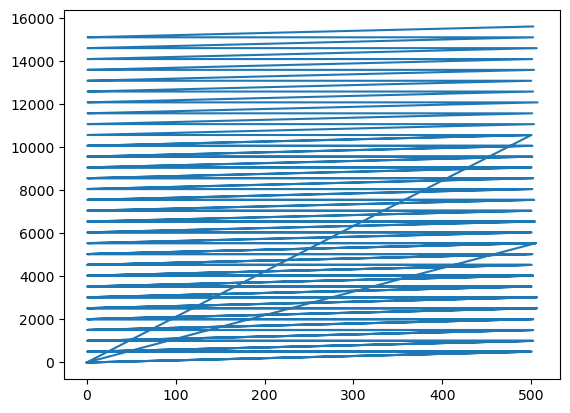

In [35]:
plt.plot(rhc_combo1['Iteration'], rhc_combo1['FEvals'])
plt.show()

### Plotting

In [7]:
# Create/display fitness curve plot for selected algorithm.
# plt.plot(nn.fitness_curve)
# plt.ylabel('Relative Fitness Found')
# plt.show()